<a href="https://colab.research.google.com/github/Anjasfedo/data-analysis/blob/main/sistem_rekomendasi_amazon_fine_food_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impor Library & Package

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import shutil
from sklearn.metrics import mean_squared_error
import numpy as np


In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Data Understanding

Penjelasan Fitur:
- **Id**: ID unik untuk setiap review.
- **ProductId**: ID produk makanan yang diulas.
- **UserId**: ID pengguna yang memberikan review.
- **ProfileName**: Nama profil pengguna.
- **HelpfulnessNumerator**: Jumlah user yang menilai review ini 'helpful'.
- **HelpfulnessDenominator**: Total user yang memberi penilaian helpfulness.
- **Score**: Rating produk (1–5).
- **Time**: Waktu (timestamp) review diberikan.
- **Summary**: Ringkasan review.
- **Text**: Isi lengkap review.

In [ ]:
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/amazon-fine-food-reviews


In [ ]:
shutil.copy(path + "/Reviews.csv", "Reviews.csv")

'Reviews.csv'

In [ ]:
df = pd.read_csv('Reviews.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
n_users = df['UserId'].nunique()
n_products = df['ProductId'].nunique()
print(f"Total unique users: {n_users}")
print(f"Total unique products: {n_products}")

Total unique users: 256059
Total unique products: 74258


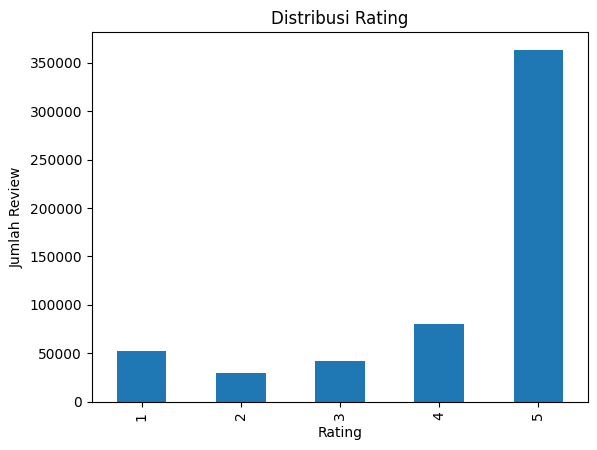

In [ ]:
df['Score'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah Review')
plt.show()

Distribusi rating cenderung berat ke rating tinggi (mayoritas review memberi skor 5).

In [ ]:
print(df.isnull().sum())

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


- Dataset sangat besar, dengan >256 ribu user unik dan >74 ribu produk unik.
- Distribusi rating condong ke rating tinggi (5).
- Data cukup bersih, missing value sangat sedikit dan hanya di kolom non-kritis.

# Data Preparation

## Cleaning Data
Karena jumlah missing value pada kolom `ProfileName` dan `Summary` sangat sedikit (masing-masing 26 dan 27 dari 568.454 baris), dan kedua kolom ini tidak digunakan sebagai fitur utama pada collaborative filtering, kita dapat mengabaikan atau menghapus baris tersebut jika perlu. Namun, semua kolom kunci (`ProductId`, `UserId`, `Score`, `Text`) tidak memiliki missing value.

In [ ]:
df = df.dropna(subset=["UserId", "ProductId", "Score"])

## Encoding User dan Produk
Untuk memudahkan proses embedding pada model, kita encode `UserId` dan `ProductId` menjadi indeks integer.

In [ ]:
user_ids = df['UserId'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

product_ids = df['ProductId'].unique().tolist()
product_to_product_encoded = {x: i for i, x in enumerate(product_ids)}
product_encoded_to_product = {i: x for i, x in enumerate(product_ids)}

df['user'] = df['UserId'].map(user_to_user_encoded)
df['product'] = df['ProductId'].map(product_to_product_encoded)
df['Score'] = df['Score'].astype(np.float32)

df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,user,product
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0,0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1.0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1,1
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4.0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2,2
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2.0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,3,3
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5.0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,4,4


In [ ]:
num_users = len(user_to_user_encoded)
num_products = len(product_encoded_to_product)
min_rating = df['Score'].min()
max_rating = df['Score'].max()
print(f"Number of users: {num_users}")
print(f"Number of products: {num_products}")
print(f"Min rating: {min_rating}")
print(f"Max rating: {max_rating}")

Number of users: 256059
Number of products: 74258
Min rating: 1.0
Max rating: 5.0


## Split Data: Training dan Validation
Data diacak terlebih dahulu, lalu dibagi menjadi 80% untuk training dan 20% untuk validation. Skor rating dinormalisasi ke skala 0-1 untuk memudahkan training.

In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[['user', 'product']].values
y = df['Score'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * df.shape[0])
x_train, x_val = x[:train_indices], x[train_indices:]
y_train, y_val = y[:train_indices], y[train_indices:]

# Modeling
Setelah data siap, kita masuk ke tahap pembuatan dan pelatihan model sistem rekomendasi menggunakan **Collaborative Filtering** berbasis Neural Network (Matrix Factorization dengan embedding). Model yang akan kita bangun bertujuan mempelajari representasi (embedding) dari setiap user dan produk, lalu memprediksi skor kecocokan antara user dan produk tersebut.

## Definisikan Model RecommenderNet
Model menggunakan dua embedding layer (untuk user dan produk), masing-masing dipadukan dengan bias. Output model berupa skor prediksi rating dengan aktivasi sigmoid agar berada pada rentang [0, 1].


In [ ]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_products, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(num_users, embedding_size,
                                               embeddings_initializer='he_normal',
                                               embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.user_bias = layers.Embedding(num_users, 1)
        self.product_embedding = layers.Embedding(num_products, embedding_size,
                                                  embeddings_initializer='he_normal',
                                                  embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.product_bias = layers.Embedding(num_products, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        product_vector = self.product_embedding(inputs[:, 1])
        product_bias = self.product_bias(inputs[:, 1])
        dot_user_product = tf.tensordot(user_vector, product_vector, 2)
        x = dot_user_product + user_bias + product_bias
        return tf.nn.sigmoid(x)

##  Kompilasi Model

Kita gunakan:
- **Loss function**: Binary Crossentropy (karena skor sudah dinormalisasi ke 0-1)
- **Optimizer**: Adam
- **Metrics**: Root Mean Squared Error (RMSE)

In [ ]:
model = RecommenderNet(num_users, num_products, embedding_size=50)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

## Training Model

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=100,
    validation_data=(x_val, y_val)
)

Epoch 1/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.5889 - root_mean_squared_error: 0.3791 - val_loss: 0.5092 - val_root_mean_squared_error: 0.3267
Epoch 2/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.5115 - root_mean_squared_error: 0.3255 - val_loss: 0.5420 - val_root_mean_squared_error: 0.3430
Epoch 3/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.5507 - root_mean_squared_error: 0.3404 - val_loss: 0.5725 - val_root_mean_squared_error: 0.3573
Epoch 4/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.6682 - root_mean_squared_error: 0.3936 - val_loss: 0.5665 - val_root_mean_squared_error: 0.3433
Epoch 5/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.7453 - root_mean_squared_error: 0.4041 - val_loss: 0.5835 - val_root_mean_squared_error: 0.3448
Epoch 6/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.8519 - root_mean_squared_error: 0.4403 - val_loss: 0.6942 - val_root_mean_squared_error: 0.3510
Epoch 7/10
1777/1777 ━━━━━━━━━━━━━

## Visualisasi Proses Training

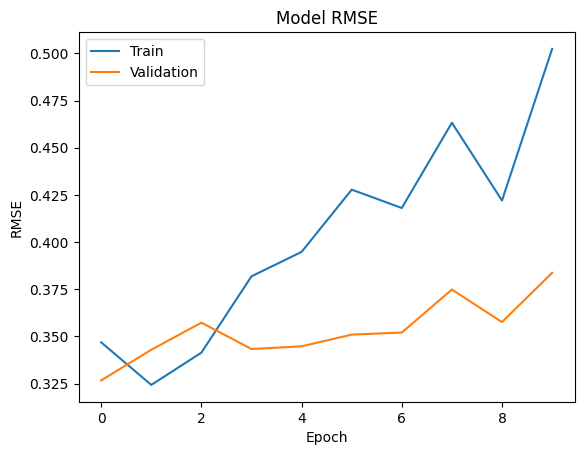

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluation
Setelah model collaborative filtering selesai dilatih, tahap selanjutnya adalah mengevaluasi performa model. Evaluasi dilakukan untuk mengetahui seberapa baik model memprediksi rating dan memberikan rekomendasi yang relevan.

## Root Mean Squared Error (RMSE)

Selama proses training, kita sudah memantau metrik RMSE pada data training dan validasi. RMSE mengukur rata-rata error prediksi rating model terhadap rating sebenarnya (setelah dinormalisasi ke 0-1).


In [ ]:
y_pred = model.predict(x_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.4f}")

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation RMSE: 0.3287


Nilai RMSE yang kecil menunjukkan model semakin baik dalam memprediksi rating user terhadap produk.


# Percobaan Sistem Rekomendasi (Recommendation Experiment)
Tahap ini bertujuan menguji kemampuan sistem dalam memberikan rekomendasi produk makanan untuk user tertentu. Prosesnya adalah:

1. **Ambil sample user secara acak**.
2. **Identifikasi produk yang sudah pernah di-rating oleh user**.
3. **Tentukan produk yang belum pernah di-rating user** (produk kandidat rekomendasi).
4. **Prediksi skor semua produk kandidat** dengan model.
5. **Ambil Top-N produk dengan skor tertinggi** sebagai rekomendasi.
6. **Bandingkan dengan produk yang pernah diberi rating tinggi oleh user**.

In [ ]:
user_id = df['UserId'].sample(1).iloc[0]
user_encoded = user_to_user_encoded[user_id]

products_rated_by_user = df[df['UserId'] == user_id]['ProductId'].values

products_not_rated = list(set(product_ids) - set(products_rated_by_user))

products_not_rated_encoded = [product_to_product_encoded[x] for x in products_not_rated]

user_array = np.array([user_encoded] * len(products_not_rated_encoded))
product_array = np.array(products_not_rated_encoded)
input_array = np.vstack([user_array, product_array]).T

predicted_scores = model.predict(input_array).flatten()

top_indices = predicted_scores.argsort()[-10:][::-1]
recommended_product_indices = [products_not_rated_encoded[i] for i in top_indices]
recommended_product_ids = [product_encoded_to_product[i] for i in recommended_product_indices]

print(f"Rekomendasi produk untuk user: {user_id}")
print("="*40)
print("Produk dengan rating tinggi dari user:")
top_user_products = (
    df[df['UserId'] == user_id]
    .sort_values(by='Score', ascending=False)
    .head(5)['ProductId']
    .values
)
for pid in top_user_products:
    print(pid)
print("="*40)
print("Top 10 rekomendasi produk:")
for pid in recommended_product_ids:
    print(pid)

2321/2321 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Rekomendasi produk untuk user: A21HPOBT647UHO
Produk dengan rating tinggi dari user:
B00384ABT0
B0016687F2
B00384GGLC
B00384GGGC
Top 10 rekomendasi produk:
B000NMJWZO
B000GAT6NG
B003B3OOPA
B001E8DHPW
B004EAGP74
B001EQ5JLE
B001EO5Q64
B000ED9L9E
B0030VJ79Q
B0026RQTGE
